In [1]:
import os
import pandas as pd
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from pyirf.spectral import CRAB_MAGIC_JHEAP2015, PowerLaw, LogParabola
from pyirf.statistics import li_ma_significance
from scipy.stats import moyal
from gammapy.modeling.models import EBLAbsorptionNormSpectralModel

## Set cut efficiency

In [2]:
#
# Cut efficiency: the same for the gammaness cut and the theta cut
# Options: 0.4, 0.7, 0.9
#
# Recommended: 
# 0.7: standard cuts (safer for spectral analysis)
# 0.4: tight cuts, better for detection of weak sources
#
cut_efficiency = 0.7

## Load files which contain the instrument response function and show table contents
They characterize the average performance of LST1 within 1 degree off-axis (computed from diffuse gamma MC and
real data for the cosmic ray rates)

In [3]:
#
# Load files for the requested efficiency:
#
datadir = os.environ['LSTCHAIN'] + '/data/'

In [4]:
input_filename = datadir + f'LST1_gamma_irf_gheffi_{cut_efficiency:.2f}_theffi_{cut_efficiency:.2f}.csv'
gamma_data = pd.read_csv(input_filename)

input_filename = datadir + f'LST1_backg_irf_gheffi_{cut_efficiency:.2f}_theffi_{cut_efficiency:.2f}.csv'
background_data = pd.read_csv(input_filename)

In [5]:
gamma_data

,ZD_deg,Etrue_min_TeV,Etrue_max_TeV,Aeff_m2,emig_mu_loc,emig_mu_scale,emig_model
0,6.00,0.011220,0.014125,1.523558e+03,2.173221,0.254397,moyal
1,6.00,0.014125,0.017783,3.045447e+03,1.768732,0.234880,moyal
2,6.00,0.017783,0.022387,5.419198e+03,1.459977,0.216000,moyal
3,6.00,0.022387,0.028184,8.858634e+03,1.212684,0.190464,moyal
4,6.00,0.028184,0.035481,1.299283e+04,1.050773,0.184902,moyal
...,...,...,...,...,...,...,...
345,66.44,11.220185,14.125375,1.919827e+06,0.936101,0.148488,gauss
346,66.44,14.125375,17.782794,1.964986e+06,0.933643,0.150116,gauss
347,66.44,17.782794,22.387211,2.261285e+06,0.938107,0.146014,gauss
348,66.44,22.387211,28.183829,2.116637e+06,0.945268,0.145841,gauss


In [6]:
background_data

,ZD_deg,Ereco_min_TeV,Ereco_max_TeV,BckgRate_per_second,Theta_cut_deg,Gammaness_cut
0,6.00,0.012589,0.019953,0.158753,0.320000,0.112810
1,6.00,0.019953,0.031623,11.244392,0.320000,0.176081
2,6.00,0.031623,0.050119,17.278245,0.320000,0.189099
3,6.00,0.050119,0.079433,10.838075,0.320000,0.197615
4,6.00,0.079433,0.125893,2.151692,0.267352,0.316888
...,...,...,...,...,...,...
185,66.44,7.943282,12.589254,0.002647,0.133676,0.387355
186,66.44,12.589254,19.952623,0.001408,0.134832,0.398923
187,66.44,19.952623,31.622777,0.000598,0.138468,0.426601
188,66.44,31.622777,50.118723,0.000177,0.133650,0.474480


In [7]:
# CHECK that we have the same pointing zenith values in both tables:
assert np.alltrue(np.unique(gamma_data.ZD_deg) == np.unique(background_data.ZD_deg))

# Available zeniths:
zenith = np.unique(gamma_data.ZD_deg)
print('Available zeniths:', zenith, '(degrees)')

Available zeniths: [ 6.     9.579 16.08  23.16  30.39  37.66  44.92  52.16  59.34  66.44 ] (degrees)


## Select zenith bin

In [8]:
# Choose the bins among those above. Just set the bin number (from 0)
# Make sure you choose values which make sense for the declination of your source

zd_bin = 2
print('Selected ZD = ', zenith[zd_bin], 'degrees')

# Cuts for tables:
zd_selection_gamma = abs(gamma_data.ZD_deg - np.unique(gamma_data.ZD_deg)[zd_bin])<0.01
zd_selection_backg = abs(background_data.ZD_deg - np.unique(background_data.ZD_deg)[zd_bin])<0.01

Selected ZD =  16.08 degrees


## ON to OFF exposure

In [9]:
# Ratio of ON to OFF exposure (Li & Ma's "alpha")
# For standard wobble offset (0.4 deg) reasonable values are alpha=0.333 (3 off regions) above 0.2 TeV, 
# and alpha=1 below 0.2 TeV.  For testing sensitivity with the standard definition, set alpha=0.2

alpha = 1 # 0.333  # 1

## Observation time

In [10]:
effective_obs_time = 34 * u.h 

## Source redshift

In [11]:

redshift = 0

# We will apply the Dominguez EBL model to simulate the absorption


try:
    os.environ['GAMMAPY_DATA']
except:
    # SET HERE THE GAMMAPY_DATA ENV VARIABLE IN CASE IT IS NOT SET
    # YOU MUST SET THE PATH TO THE CORRESPONDING DIRECTORY IN THE CONDA ENVIRONMENT YOU ARE USING:
    os.environ['GAMMAPY_DATA'] = '/fefs/aswg/workspace/abelardo.moralejo/miniconda3/envs/lst-dev/lib/python3.11/site-packages/gammapy/gammapy-datasets/1.1'

dominguez = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

## Source (intrinsic) spectrum 

In [12]:
# Set here the simulated intrinsic spectrum (must take as argument an astropy quantity with energy units)

# Crab Nebula:
def intrinsic_dFdE(E):
    return CRAB_MAGIC_JHEAP2015(E)  # Crab Nebula, MAGIC log-parabola

# def intrinsic_dFdE(E):
#     return PowerLaw(normalization=5e-8 / (u.TeV * u.cm**2 * u.s), 
#                     index=-2.0, 
#                     e_ref=0.1 * u.TeV)(E)

# def intrinsic_dFdE(E):
#     return LogParabola(normalization=5e-8 / (u.TeV * u.cm**2 * u.s), 
#                     a=-2.0, b =-0.2, 
#                     e_ref=0.1 * u.TeV)(E)

In [13]:
# After EBL absorption:
def dFdE(E):
    return intrinsic_dFdE(E) * dominguez.evaluate(E, redshift, 1)

## END of user settings
#

In [14]:
# Other settings (change only for tests)

min_signal_to_backg_ratio = 0.01     # safeguard against systematics
min_signi_in_flux_point = 3          # minimum significance to display a flux point
integral_significance_threshold = 5  # "Detection significance"

min_Aeff = 100 *u.m**2         # Minimum required Aeff in Etrue bins. 
                               # Just to avoid Etrue bins with little MC stats, hence noisy!

In [15]:
erecobins = background_data[zd_selection_backg].Ereco_min_TeV.to_numpy()
erecobins = np.append(erecobins, background_data[zd_selection_backg].Ereco_max_TeV.to_numpy()[-1])

In [16]:
etruebins = gamma_data[zd_selection_gamma].Etrue_min_TeV.to_numpy()
etruebins = np.append(etruebins, gamma_data[zd_selection_gamma].Etrue_max_TeV.to_numpy()[-1])

effective_area = gamma_data.Aeff_m2[zd_selection_gamma].to_numpy()*u.m**2

# Model to characterize the energy migration matrix (gauss or moyal):
emig_model = gamma_data[zd_selection_gamma].emig_model.to_numpy()

# Parameters to characterize the energy migration matrix:
loc = gamma_data[zd_selection_gamma].emig_mu_loc.to_numpy()
scale = gamma_data[zd_selection_gamma].emig_mu_scale.to_numpy()


# Now we extrapolate Aeff to higher Etrue by using the same value of the highest available energy:
# (it is better than having zeros!) We also assume the same E-migration
factor = etruebins[-1]/etruebins[-2] # step in energy in each bin
while etruebins[-1] < 80: # extend to 80 TeV at least
    etruebins = np.append(etruebins, etruebins[-1]*factor)
    effective_area = np.append(effective_area, effective_area[-1])
    emig_model = np.append(emig_model, emig_model[-1])
    loc = np.append(loc, loc[-1])
    scale = np.append(scale, scale[-1])

In [17]:
etruebincenters = (etruebins[:-1]*etruebins[1:])**0.5
erecobincenters = (erecobins[:-1]*erecobins[1:])**0.5

In [18]:
# Exclude too low eff. areas (in general, unreliable due to low MC stats)

effective_area[effective_area<min_Aeff] = 0

# Exclude also Ereco bins which have Ereco values below the first Etrue value with valid Aeff:
ereco_mask = erecobincenters >= etruebincenters[np.where(effective_area>0)[0][0]]

In [19]:
def integrate (dfde1, dfde2, e1, e2):
    # We cannot let numpy deal with the units, sometimes rounding leads to wrong units in result!
    # like TeV^(1e-15) :-D
    # in power-law approximation:
    gamma = np.log(dfde2/dfde1) / np.log(e2/e1)
    e1tev = e1.to_value(u.TeV)
    e2tev = e2.to_value(u.TeV)
    
    integral = dfde1.to_value(1/(u.TeV * u.cm**2 * u.s)) / (gamma+1) * e1tev**(-gamma) * (e2tev**(gamma+1) - e1tev**(gamma+1))
    return integral # (1/u.s/u.cm**2)

In [20]:
integrated_flux = []
for etruemin, etruemax in zip(etruebins[:-1], etruebins[1:]):
    integrated_flux.append(integrate(dFdE(etruemin*u.TeV),
                                     dFdE(etruemax*u.TeV),
                                     etruemin*u.TeV, 
                                     etruemax*u.TeV))
integrated_flux = np.array(integrated_flux)

# Too strong EBL absorption produces NaNs in high-E bins, jus trplace by 0's:
integrated_flux[np.isnan(integrated_flux)] = 0
    
integrated_flux = np.array(integrated_flux) * 1/(u.s * u.cm**2)

## Effective area

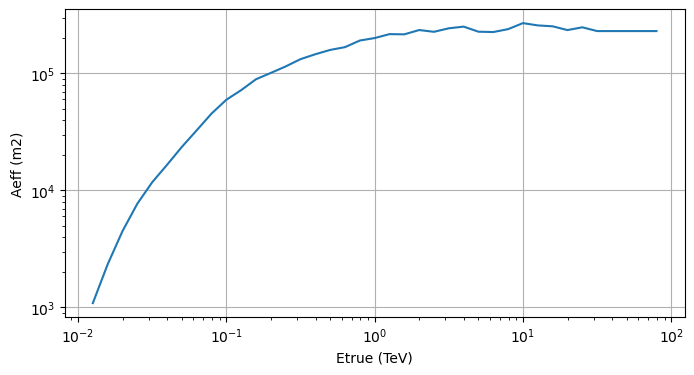

In [21]:
plt.figure(figsize=(8,4))
plt.plot(etruebincenters, effective_area)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Etrue (TeV)')
plt.ylabel('Aeff (m2)')
plt.grid()

## Background rate

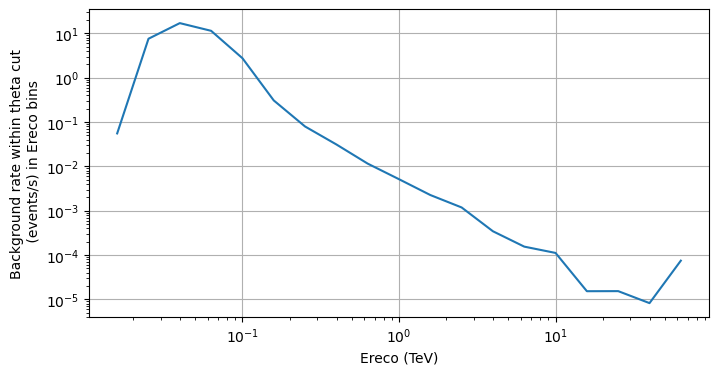

In [22]:
plt.figure(figsize=(8,4))
plt.plot(erecobincenters[ereco_mask], 
         background_data[zd_selection_backg].BckgRate_per_second.to_numpy()[ereco_mask])
plt.xlabel('Ereco (TeV)')
plt.ylabel('Background rate within theta cut\n (events/s) in Ereco bins')
plt.yscale('log')
plt.xscale('log')
plt.grid()

In [23]:
total_gamma_rate = (integrated_flux*effective_area).to(1/u.s)
print(f'Total gamma rate after cuts: {total_gamma_rate.sum().to_value(1/u.s):.3f} events/s')

Total gamma rate after cuts: 0.897 events/s


In [24]:
# Number of realizations (random numbers taken from gaussian) for E-migration simulation 
num_realizations = 10000

(0.1, 4167178.6876828154)

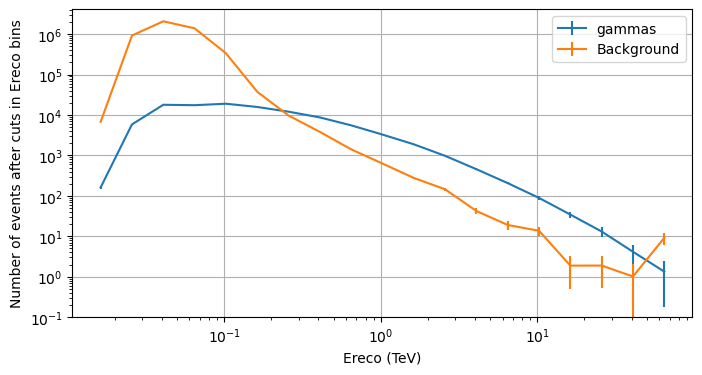

In [25]:
plt.figure(figsize=(8,4))

total_bg_counts = effective_obs_time.to_value(u.s) * background_data[zd_selection_backg].BckgRate_per_second.to_numpy()
total_signal_counts = np.zeros(zd_selection_backg.sum())

for ietrue in range(len(etruebincenters)):
    etrue = etruebincenters[ietrue]
    
    gamma_rate = total_gamma_rate[ietrue]

    
    if emig_model[ietrue] == 'gauss':
        counts, _ = np.histogram(etrue*np.random.normal(loc[ietrue], scale[ietrue], num_realizations),
                                 bins=erecobins)
                  
    elif emig_model[ietrue] == 'moyal':
        counts, _ = np.histogram(etrue*moyal.rvs(loc[ietrue], scale[ietrue], num_realizations),
                                 bins=erecobins)
    else:
        continue
    

    total_signal_counts += gamma_rate * effective_obs_time * counts / num_realizations
    # print(gamma_rate * effective_obs_time * counts / num_realizations)

    
# Now set to zero values below the "reliable minimum energy":
total_signal_counts[~ereco_mask] = 0
total_bg_counts[~ereco_mask] = 0
    
plt.errorbar(0.5*(erecobins[:-1]+erecobins[1:]), total_signal_counts, total_signal_counts**0.5,
             label='gammas')
plt.errorbar(0.5*(erecobins[:-1]+erecobins[1:]), total_bg_counts, total_bg_counts**0.5,
             label='Background')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Ereco (TeV)')
plt.ylabel('Number of events after cuts in Ereco bins')
plt.grid()
plt.ylim(0.1, 2*np.max(total_bg_counts))
# plt.xlim(10, 80)

In [26]:
significance = li_ma_significance(total_signal_counts+total_bg_counts,
                                  total_bg_counts/alpha, alpha)

# integrating from each Ereco to max Ereco
integral_signal_counts = np.cumsum(total_signal_counts[::-1])[::-1]
integral_bg_counts = np.cumsum(total_bg_counts[::-1])[::-1]

integral_significance = li_ma_significance(integral_signal_counts+integral_bg_counts,
                                           integral_bg_counts/alpha, alpha)

## Signal to background ratio and significance in Ereco bins

In [27]:
signal_to_background_ratio = total_signal_counts / total_bg_counts

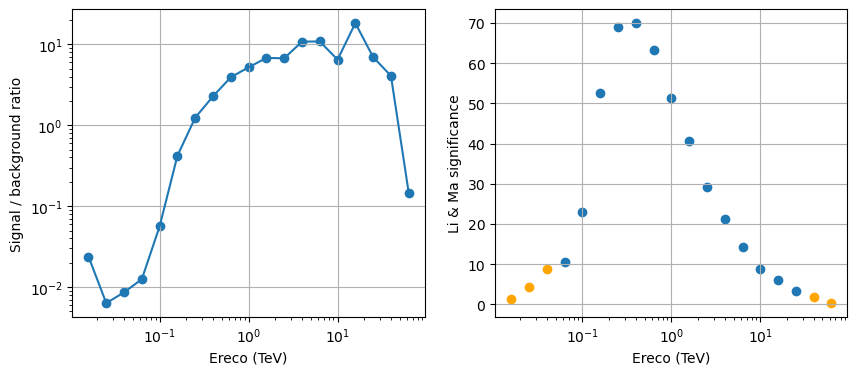

In [28]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1, 2, 1)
plt.plot(erecobincenters, signal_to_background_ratio)
plt.scatter(erecobincenters, signal_to_background_ratio)
plt.grid()
plt.xlabel('Ereco (TeV)')
plt.ylabel('Signal / background ratio')
plt.yscale('log')
plt.xscale('log')

fig.add_subplot(1, 2, 2)
points_mask = ((signal_to_background_ratio >= min_signal_to_backg_ratio) &
               (significance >= min_signi_in_flux_point))
plt.scatter(erecobincenters[points_mask], significance[points_mask])

plt.scatter(erecobincenters[~points_mask], significance[~points_mask], color='orange')

plt.grid()
plt.xlabel('Ereco (TeV)')
plt.ylabel('Li & Ma significance')
plt.xscale('log')

## Integral significance (for Ereco>xx)

*************************
Detection successful! :-D


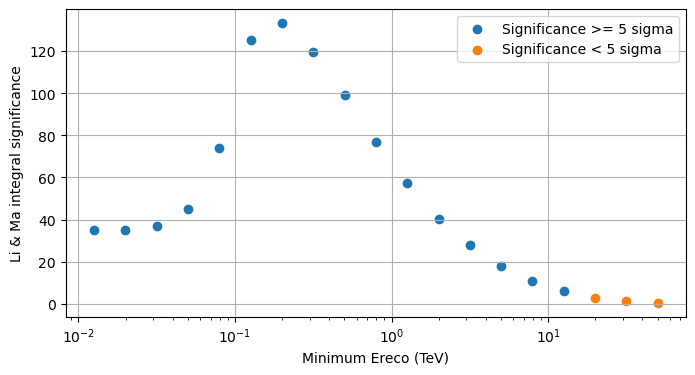

In [29]:
plt.figure(figsize=(8,4))
mask = integral_significance >= integral_significance_threshold
plt.scatter(erecobins[:-1][mask], integral_significance[mask], 
            label=f'Significance >= {integral_significance_threshold} sigma')
plt.scatter(erecobins[:-1][~mask], integral_significance[~mask],
            label=f'Significance < {integral_significance_threshold} sigma')
plt.grid()
plt.xlabel('Minimum Ereco (TeV)')
plt.ylabel('Li & Ma integral significance')
plt.xscale('log')

if mask.sum() > 0:
    print('*************************')
    print('Detection successful! :-D')
else:
    print('****************')
    print('No detection :-C')
plt.legend()
plt.show()

## Simulated SED from observation (Asimov dataset)
The fluxes & uncertainties are computed in the Ereco bins, and shamelessly placed at the same value in Etrue, and at the expected flux level. 
In reality an energy unfolding process is needed... what is shown below is just a an estimate of what the spectrum will look like - but pretty accurate for the purpose of observation planning.

In [30]:
noff = total_bg_counts / alpha
non = total_signal_counts + total_bg_counts
# excess = non - alpha * noff (= total_signal_counts in Asimov dataset)
excess_error = (non + alpha**2 * noff)**0.5
relative_excess_error = excess_error / total_signal_counts

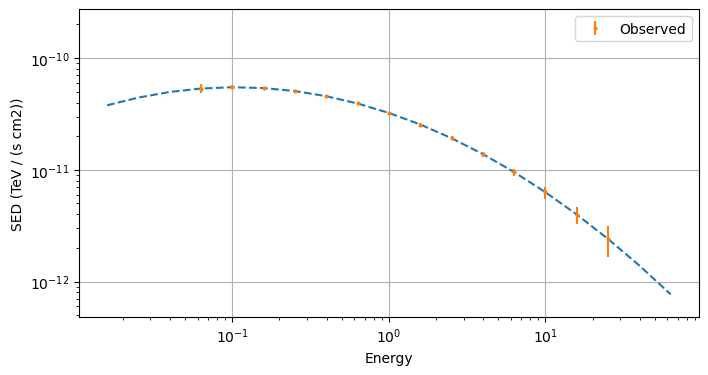

In [31]:
plt.figure(figsize=(8,4))
SED = (erecobincenters*u.TeV)**2 * dFdE(erecobincenters*u.TeV)
SED_error = SED*relative_excess_error
intrinsic_SED = (erecobincenters*u.TeV)**2 * intrinsic_dFdE(erecobincenters*u.TeV)

if redshift > 0:
    plt.plot(erecobincenters*u.TeV, intrinsic_SED, '--', color='lightgrey', label='intrinsic')
plt.plot(erecobincenters*u.TeV, SED, '--')

plt.errorbar(erecobincenters[points_mask]*u.TeV, SED[points_mask], 
             yerr=SED_error[points_mask], fmt='o', markersize=2, label='Observed')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Energy')
plt.ylabel(f'SED ({SED.unit})')
plt.ylim(SED[points_mask].min().value*0.2, SED[points_mask].max().value*5)
plt.legend()
plt.grid()